In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
plt.style.use('fivethirtyeight')
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex = True)

In [84]:
class LNN:
    def __init__(self, N, v = None, w = None, sigmaS = 1., sigmaI = 1., sigmaG = 1., nonlinearity = None):
        self.N = N
        if v is None:
            self.v = 0
        else:
            self.v = v
        
        if w is None:
            self.w = 0
        else:
            self.w = w
        
        if nonlinearity is None:
            self.nonlinearity = self.squared
        else:
            self.nonlinearity = nonlinearity
        
        self.sigmaS = sigmaS
        self.sigmaI = sigmaI
        self.sigmaG = sigmaG
    
    def squared(self,x):
        return x**2

    def simulate(self,trials):
        s = np.random.normal(loc = 0., scale = sigmaG, size = trials)
        injected_noise = np.random.normal(loc = 0., scale = sigmaI, size = trials)
        private_noise = np.random.normal(loc = 0., scale = sigmaG, size = (self.N, trials))
        l = np.outer(self.v, s) + np.outer(self.w, injected_noise) + private_noise
        r = self.nonlinearity(l)
        return r
    
    def fisher_info_linear_stage(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        fisher_info = (self.sigmaG**2 * v2 + self.sigmaI**2 * (v2 * w2 - vdotw))/(self.sigmaG**2 * (self.sigmaG**2 + self.sigmaI**2 * w2))
        return fisher_info
    
    def mutual_analytic(self):
        v2 = np.sum(self.v**2)
        w2 = np.sum(self.w**2)
        vdotw = np.sum(self.v * self.w)
        ww = np.outer(self.w, self.w)
        wv = np.outer(self.w, self.v)
        vw = np.outer(self.v, self.w)
        vv = np.outer(self.v, self.v)
        
        sigma_inj = self.sigmaG**2 + self.sigmaI**2 * w2
        sigma_stim = self.sigmaG**2 + self.sigmaS**2 * v2
        kappa = sigma_inj * sigma_stim - self.sigmaI**2 * self.sigmaS**2 * vdotw**2
        
        # first term
        I1 = -np.log(self.sigmaG) + 0.5 * np.log(kappa/sigma_inj)
        
        # second term
        A1 = -self.sigmaI**2 * sigma_stim/kappa
        A2 = self.sigmaI**2 * self.sigmaS**2 * vdotw/kappa
        A3 = -self.sigmaS**2 * sigma_inj/kappa
        B1 = -(self.sigmaI**4 * self.sigmaS**2 * vdotw**2)/(kappa * sigma_inj)
        
        A = 1./(2 * self.sigmaG**2) * (np.identity(self.N) + A1 * ww + A2 * (vw + wv)  + A3 * vv)
        A_inv = 2 * (self.sigmaG**2 * np.identity(self.N) + self.sigmaS**2 * vv + self.sigmaI**2 * ww)
        
        B = B1 * ww + A2 * wv + A2 * vw + A3
    
        I2 = 1./(2. * self.sigmaG**2) * np.trace(np.dot(B, A_inv))
        
        # third term
        gamma = (2 * self.sigmaG**2 + self.sigmaS**2 * v2) * (self.sigmaG**2 + self.sigmaI**2 * w2) - self.sigmaI**2 * self.sigmaS**2 * vdotw**2
        D = gamma * (-self.sigmaI**4 * vdotw**2 * ww + self.sigmaI**2 * sigma_inj * vdotw * wv + self.sigmaI**2 * sigma_inj * vdotw * vw - (self.sigmaG**2+ self.sigmaI**2 * w2)**2 * vv)
        #C = kappa * self.sigmaG**2 * sigma_inj * (self.sigmaG**2 * v2 + self.sigmaI**2 * (v2 * w2 - vdotw**2))
        I3 = -self.sigmaS**2/(2 * kappa) * (self.sigmaG**2 * v2 + self.sigmaI**2 * (v2 * w2 - vdotw**2))
        #np.trace(np.dot(D, A_inv))
        I4 = -self.sigmaS**2/(2 * self.sigmaG**2 * kappa**2 * sigma_inj) * np.trace(np.dot(D, A_inv))
        return I1 + I2 + I3 + I4

In [91]:
ns1 = np.arange(500)
muts1 = np.zeros(ns1.shape)

for idx, n in enumerate(ns1):
    lnn = LNN(n, v = np.ones(n), w = np.ones(n))
    muts1[idx] = lnn.mutual_analytic()

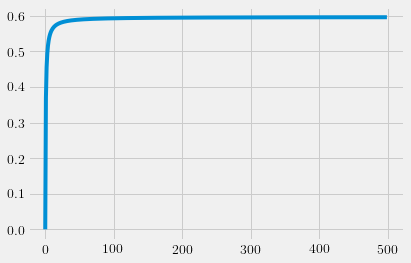

In [92]:
plt.plot(ns1,muts1)

In [93]:
ns2 = np.arange(2, 500, 2)
muts2 = np.zeros(ns2.shape)

for idx, n in enumerate(ns2):
    v = np.ones(n)
    w = np.concatenate((np.ones(int(n/2)), 2 * np.ones(int(n/2))))
    lnn = LNN(n, v = v, w = w)
    muts2[idx] = lnn.mutual_analytic()

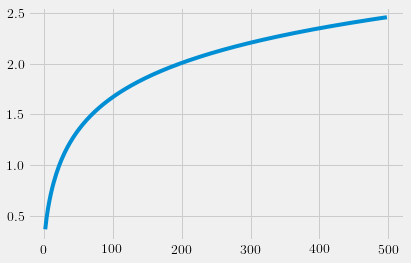

In [94]:
plt.plot(ns2,muts2)

In [96]:
ns3 = np.arange(3, 500, 3)
muts3 = np.zeros(ns3.shape)
for idx, n in enumerate(ns3):
    v = np.ones(n)
    w = np.concatenate((np.ones(int(n/3)), 2 * np.ones(int(n/3)), 3 * np.ones(int(n/3))))
    lnn = LNN(n, v = v, w = w)
    muts3[idx] = lnn.mutual_analytic()

nsN = np.arange(1, 500, 1)
mutsN = np.zeros(nsN.shape)
for idx, n in enumerate(nsN):
    v = np.ones(n)
    w = np.arange(1, n+1)
    lnn = LNN(n, v = v, w = w)
    mutsN[idx] = lnn.mutual_analytic()

In [100]:
ns0 = np.arange(500)
muts0 = np.zeros(ns0.shape)

for idx, n in enumerate(ns0):
    lnn = LNN(n, v = np.ones(n), w = np.zeros(n))
    muts0[idx] = lnn.mutual_analytic()

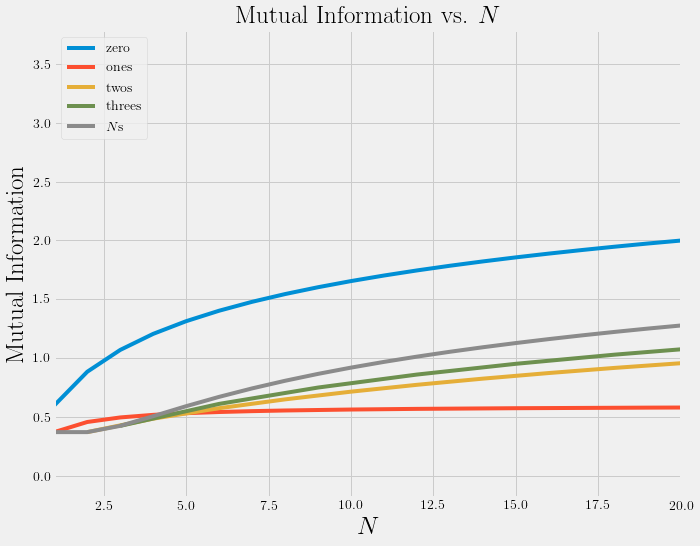

In [101]:
plt.figure(figsize = (10,8))
plt.plot(ns0, muts0, label = 'zero')
plt.plot(ns1, muts1, label = 'ones')
plt.plot(ns2, muts2, label = 'twos')
plt.plot(ns3, muts3, label = 'threes')
plt.plot(nsN, mutsN, label = r'$N$s')
plt.legend(loc = 2)
plt.xlim([1, 20])
plt.title(r'Mutual Information vs. $N$', fontsize = 25)
plt.xlabel(r'$N$', fontsize = 25)
plt.ylabel('Mutual Information', fontsize = 25)